In [1]:
import os
import pathlib
import itertools
import string
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

''' This part of the lab module is used for making transformations


HELPER FUNCTIONS: 
-----------------
ng_to_nmol
ODtime
time_to_inculate


'''
# Helper functions
def ng_to_nmol(ng, bp):

    ''' To do a transformation it is important to have the right ratio of plasmid to insert.
        In other words this is done by calculating the nanomolar ratios and this tool can do that

        parm: ng        eg. nanogram
        param: bp       eg. basepairs

        nmol = ng/(bp*650)
    '''
    if ng > 0 and bp > 0: 
        return ng/(bp*650)
    else: 
        return 'non-valid_input'

def ODtime(initialOD: float, time: float, td: float = 0.5):
    """
    - initialOD in OD
    - time in hours
    - doupling time : td in h^-1
    """
    if initialOD >= 0 and time >= 0: 
        return round(initialOD*2**(time*td),3)
    else:
        return 'non-valid_input'


def time_to_inculate(initialOD = 0.0025, td=0.4, verbose=False, transformation_time:int = 12):

    '''
    Input:

    param: initialOD in OD
    param: td is doubling time 
    param: transformations time is given as the time you want to transform
    param: verbose : Provides extra information 


    Returns:
    A plot of cell growth at different td
    Note: This is used to calculate when the cells should be used for transformation

    # OD 1 = 1 * 10^7 cells / ml
    For a succesfull S.cerevisiae transformation between 1 to 2 × 10^7 cells/ml should be used
    Normal doupling time is between 3-6 hours


    '''
    if verbose:
        print("GOAL: to get enough cells in exponential phase for transformation")
    print("Assumed that: ")
    print("- transformation time " +str(transformation_time)  +" (reached OD=1 the day after)")


    times = list(range(0, 37))
    ods_025_3     = [ODtime(initialOD,time, td=0.3) for time in times]
    ods_025_input = [ODtime(initialOD,time, td=td) for time in times]
    ods_025_5     = [ODtime(initialOD,time, td=0.5) for time in times]
    fig = plt.figure()
    ax = plt.axes()

    #ax.set_xlim(lims)
    ax.set_ylim([0, 2.2])
    ax.plot(times, [2] * len(times), 'r-', label='end of exponential phase')
    ax.plot(times, [1] * len(times), 'k-', label='target')
    ax.plot(times, ods_025_3    , label='iOD='+str(initialOD)+', td=0.3');
    ax.plot(times, ods_025_input, label='iOD='+str(initialOD)+', td=' + str(td));
    ax.plot(times, ods_025_5    , label='iOD='+str(initialOD)+', td=0.5');

    plt.xlabel('time, h^-1')
    plt.ylabel('OD')
    plt.legend()
    plt.show()


    def inoculation_time(times,ods):

        def find_closest(A, target):
            #A must be sorted
            idx = A.searchsorted(target)
            idx = np.clip(idx, 1, len(A)-1)
            left = A[idx-1]
            right = A[idx]
            idx -= target - left < right - target
            return idx
        
        
        # In how many hours will the cells have reached OD 1?
        hours_to_OD1 = times[find_closest(np.array(ods), 1)]
        print("Hours to OD = 1: \t" + str(hours_to_OD1)+ " hours")
        
        ### When do u need to innoculate?
        when_to_inoculate = 11+24 - hours_to_OD1
        print("Time of inoculation: \t" + str(when_to_inoculate) + "(the day before)")
        
        # If i innoculate now? 
        from datetime import datetime, timedelta, time
        print('\nIf you innoculate now, the cells will have reached OD= 1 by:  ', datetime.now()  + timedelta(hours=hours_to_OD1))
        
    inoculation_time(times,ods_025_input)

    
    if verbose:
        print()
        print("How to hit initialOD = 0.0025 (e.g. from colony)? Guess. Inoculate 9/10 + 1/10 'normal' colony per ~10 ml")
        print("How much volume? ~2 ml per transformation")


Assumed that: 
- transformation time 12 (reached OD=1 the day after)


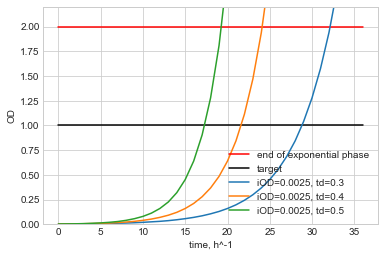

Hours to OD = 1: 	22 hours
Time of inoculation: 	13(the day before)

If you innoculate now, the cells will have reached OD= 1 by:   2022-05-31 14:46:32.400703


In [2]:
time_to_inculate(initialOD = 0.0025, td=0.4, transformation_time = 12, verbose= False)

In [3]:
#!/usr/bin/env python
# standard libraries
import os
import pathlib
import itertools
import string
import numpy as np
import pandas as pd
import pydna
import math
import pathlib
import textwrap as _textwrap
from pydna._pretty import pretty_str as _pretty_str
import csv


''' This part of the lab module is used for PCRs

HELPER FUNCTIONS: 
-----------------
pcr_volumes (formerly known as volumes)
det_proc_speed
det_elon_time
PCR_program
det_no_of_thermal_cyclers
pcr_locations1
transf_locations1

'''

def grouper(iterable, max_diff):
    prev = None
    group = []
    for item in iterable:
        if not prev or item - prev <= max_diff:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group


def pcr_volumes(vol_p_reac=10, no_of_reactions = 1, standard_reagents = [], standard_volumes = []):

    ''' Can make a reaction scheme for PCR master mixes such as:

        3-reactions:
        -----------------------
    	               vol_p_reac	vol_p_3_reac
        Template       	 1.0	        3.0
        Primer 1	     2.5	        7.5
        Primer 2	     2.5	        7.5
        H20	             19.0	        57.0
        MM	             25.0	        75.0
        Total	         50.0         	150.0
        -----------------------

        If this is used as input:
        ------------------------
        (vol_p_reac = 10,
        no_of_reactions = 6,
        standard_reagents = ["DNA","Buffer, Cutsmart","H20","Enz, USER"],
        standard_volumes = [1,1,7,1])

        The following reaction scheme will be made:
        -------------------------
                        vol_p_reac	vol_p_x_reac
        DNA	                1.0	        6.0
        Buffer, Cutsmart	1.0	        6.0
        H20	                7.0	        42.0
        Enz, USER	        1.0	        6.0
        Total	            10.0      	60.0
        -------------------------


        '''
    standard_total_volume = float(sum(standard_volumes))
    volumes_p_x = [float(val)/standard_total_volume*float(vol_p_reac) for val in standard_volumes]
    volumes_p_x_p_y_reactions = [val*no_of_reactions for val in volumes_p_x]
    volumes_p_x_p_y_reactions

    volumes_p_x_plus_total = volumes_p_x + [sum(volumes_p_x)]
    volumes_p_x_p_y_reactions_plus_total = volumes_p_x_p_y_reactions + [sum(volumes_p_x_p_y_reactions)]
    reagents_plus_total = standard_reagents + ['Total']

    volumes_df  = pd.DataFrame(data =  {'vol_p_reac': volumes_p_x_plus_total,
                                        'vol_p_'+str(no_of_reactions)+'_reac': volumes_p_x_p_y_reactions_plus_total},
                               index  = reagents_plus_total)
    return(volumes_df)


In [4]:

vol_p_reac = 10.0

no_of_reactions = 6
standard_reagents = ["DNA","Buffer, Cutsmart","H20","Enz, USER"]
standard_volumes = [1,1,7,1]

pcr_reaction_df = pcr_volumes(vol_p_reac,no_of_reactions ,standard_reagents, standard_volumes)

pcr_reaction_df

vol_p_reac  vol_p_6_reac
DNA                      1.0           6.0
Buffer, Cutsmart         1.0           6.0
H20                      7.0          42.0
Enz, USER                1.0           6.0
Total                   10.0          60.0

In [5]:
pcr_reaction_df.to_dict()

{'vol_p_reac': {'DNA': 1.0,
  'Buffer, Cutsmart': 1.0,
  'H20': 7.0,
  'Enz, USER': 1.0,
  'Total': 10.0},
 'vol_p_6_reac': {'DNA': 6.0,
  'Buffer, Cutsmart': 6.0,
  'H20': 42.0,
  'Enz, USER': 6.0,
  'Total': 60.0}}

In [6]:
df_dict ={'vol_p_reac': {'DNA': 1.0,
  'Buffer, Cutsmart': 1.0,
  'H20': 7.0,
  'Enz, USER': 1.0,
  'Total': 10.0},
 'vol_p_6_reac': {'DNA': 6.0,
  'Buffer, Cutsmart': 6.0,
  'H20': 42.0,
  'Enz, USER': 6.0,
  'Total': 60.0}}

In [7]:
pcr_reaction_df_dict = pd.DataFrame(data =df_dict)



In [8]:
#pd.testing.assert_index_equal(pcr_reaction_df_dict,pcr_reaction_df,check_names=True)

In [9]:
def det_proc_speed(amplicon):
    '''
    This function determines process speed dependent on the which polymerase is used
    '''
    
    if "proc_speed" in amplicon.forward_primer.annotations:
        print("proc_speed already set")
        return amplicon

    # proc_speed units are seconds/kb
    if amplicon.annotations['polymerase'] == "OneTaq Hot Start":
        proc_speed = 60
    elif amplicon.annotations['polymerase'] == "Q5 Hot Start":
        proc_speed = 30
    elif amplicon.annotations['polymerase'] == "Phusion":
        proc_speed = 30

    amplicon.annotations['proc_speed'] = proc_speed

    return amplicon

def det_elon_time(amplicon):

    ''' This function determines elongation time for an amplicon
    and add the elongation time to the amplicon annotations'''

    if "elongation_time" in amplicon.forward_primer.annotations:
        print("elongation_time already set")
        return amplicon

    # elongation_time units are seconds
    elongation_time = amplicon.annotations['proc_speed'] * len(amplicon)/1000
    amplicon.annotations['elongation_time'] = math.ceil(elongation_time)

    return amplicon



In [10]:
from pydna.dseqrecord import Dseqrecord
from pydna.readers import read
from pydna.amplify import pcr
from pydna.primer import Primer
from Bio.SeqRecord import SeqRecord
    
# initialize
middle = 'a'*2000
template = Dseqrecord("tacactcaccgtctatcattatcagcgacgaagcgagcgcgaccgcgagcgcgagcgca"+middle+"caggagcgagacacggcgacgcgagcgagcgagcgatactatcgactgtatcatctgatagcac")
p1 = Primer("tacactcaccgtctatcattatc")
p2 = Primer("cgactgtatcatctgatagcac").reverse_complement()
amplicon = pcr(p1, p2, template)
amplicon.annotations['polymerase'] = "OneTaq Hot Start"
det_proc_speed(amplicon)


print(    det_elon_time(amplicon))

Dseqrecord
circular: False
size: 2123
ID: 2123bp_uEC9clUhipmw1j2qRizKWJzHCHc
Name: 2123bp_PCR_prod
Description: pcr_product_description_<unknown description>
Number of features: 2
/molecule_type=DNA
/polymerase=OneTaq Hot Start
/proc_speed=60
/elongation_time=128
Dseq(-2123)
taca..gcac
atgt..cgtg


In [11]:
def well_keys_96(row = True):
    '''
    If true it generates keys for a 96 well plate by row.
    else it does it by column
    '''
    key_list = 'ABCDEFGH'

    if row == True:
        wells_keys = []
        for i in range(0,len(key_list)):
            for j in range(1,13):
                wells_keys.append(key_list[i]+str(j))

    else:
        wells_keys = []
        for i in range(1,13):
            for j in range(0,len(key_list)):
                wells_keys.append(str(key_list[j])+str(i))

    return wells_keys

well_keys = well_keys_96()


In [12]:
print(well_keys_96(row = False ))

['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2', 'A3', 'B3', 'C3', 'D3', 'E3', 'F3', 'G3', 'H3', 'A4', 'B4', 'C4', 'D4', 'E4', 'F4', 'G4', 'H4', 'A5', 'B5', 'C5', 'D5', 'E5', 'F5', 'G5', 'H5', 'A6', 'B6', 'C6', 'D6', 'E6', 'F6', 'G6', 'H6', 'A7', 'B7', 'C7', 'D7', 'E7', 'F7', 'G7', 'H7', 'A8', 'B8', 'C8', 'D8', 'E8', 'F8', 'G8', 'H8', 'A9', 'B9', 'C9', 'D9', 'E9', 'F9', 'G9', 'H9', 'A10', 'B10', 'C10', 'D10', 'E10', 'F10', 'G10', 'H10', 'A11', 'B11', 'C11', 'D11', 'E11', 'F11', 'G11', 'H11', 'A12', 'B12', 'C12', 'D12', 'E12', 'F12', 'G12', 'H12']


In [13]:
def make_virtual_plates_fromDF(f_primers:list, r_primers:list, templates:list, Dataframe_with_PCR_contents):
    '''
    THis function can make virtual plates from lists of primers and templates.
    The Pandas DataFrame is used to calculate how much pcr and h2o is needed for the reactions.
    '''

    #initializing
    source_plate1 = lab.Plate96(name="1") # Forward primers
    source_plate2 = lab.Plate96(name="2") # Reverse primers
    source_plate3 = lab.Plate96(name="3") # Templates
    source_plate4 = lab.Plate2x4(name="4") # PCR mix and H20
    well_keys = well_keys_96()
    volume_needed = len(Dataframe_with_PCR_contents)+1

    # Adding each primer/template to the virtual plates here a volume of 5 is arbitrarily chosen
    for i in range(0,len(f_primers)):
        source_plate1[well_keys[i]].add_content({f_primers[i]:1},volume= 5.0)
    for j in range(0,len(r_primers)):
        source_plate2[well_keys[j]].add_content({r_primers[j]:1},volume= 5.0)
    for k in range(0,len(templates)):
        source_plate3[well_keys[k]].add_content({templates[k]:1},volume= 5.0 )

    # Adding MM and H2O to the final plate
    source_plate4["A1"].add_content({'PCR_2x_mix':10},volume = volume_needed*10)
    source_plate4["A2"].add_content({'H2O_MQ':10},volume = volume_needed*7)

    return source_plate1, source_plate2, source_plate3, source_plate4

In [14]:
import pandas as pd
import synbiopython.lab_automation as lab
# Read in test data
test_data = pd.read_excel('../tests/files_for_testing/Random_PCR_list.xlsx')

# Add test primers and templates
fwd_primers = ['F0069','F0078', 'F0083','F0088','F0093','F0098','F00103','F00108']
rev_primers = ['R00174','R00175','R00176','R00177']
templates = ['pRPL15B']

In [15]:
f, r, t, pcr_mix = make_virtual_plates_fromDF(fwd_primers, rev_primers, templates, test_data)

In [16]:
type(f)

synbiopython.lab_automation.containers.builtin_containers.Plate96

In [17]:
f.index_to_wellname(1)

'A1'

In [18]:
f.num_wells

96

In [19]:
print(f.columns)

{1: ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1'], 2: ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2'], 3: ['A3', 'B3', 'C3', 'D3', 'E3', 'F3', 'G3', 'H3'], 4: ['A4', 'B4', 'C4', 'D4', 'E4', 'F4', 'G4', 'H4'], 5: ['A5', 'B5', 'C5', 'D5', 'E5', 'F5', 'G5', 'H5'], 6: ['A6', 'B6', 'C6', 'D6', 'E6', 'F6', 'G6', 'H6'], 7: ['A7', 'B7', 'C7', 'D7', 'E7', 'F7', 'G7', 'H7'], 8: ['A8', 'B8', 'C8', 'D8', 'E8', 'F8', 'G8', 'H8'], 9: ['A9', 'B9', 'C9', 'D9', 'E9', 'F9', 'G9', 'H9'], 10: ['A10', 'B10', 'C10', 'D10', 'E10', 'F10', 'G10', 'H10'], 11: ['A11', 'B11', 'C11', 'D11', 'E11', 'F11', 'G11', 'H11'], 12: ['A12', 'B12', 'C12', 'D12', 'E12', 'F12', 'G12', 'H12']}


In [20]:
f.name

'1'

In [21]:
f.list_well_data_fields

<bound method Plate.list_well_data_fields of Plate96(1)>

In [22]:
def picklist_from_plates(F_primer_plate, R_primer_plate, Templates_plate, MM_H20_plate, PCR_dataframe):
    '''This function can generate picklist from virtual plates and pandas dataframe with PCR components'''

    FORWARD_PRIMERS = F_primer_plate.to_pandas_dataframe()
    REVERSE_PRIMERS = R_primer_plate.to_pandas_dataframe()
    TEMPLATES = Templates_plate.to_pandas_dataframe()
    MM_H2O = MM_H20_plate.to_pandas_dataframe()

    destination_plate = lab.Plate96(name="5")
    picklist = lab.PickList()
    counter = 0

    # FIRST WE CHECK WICH COMPONENTS WE NEED FOR THE PCRs
    for index,row in PCR_dataframe.iterrows():
        templates = row['Template']
        f_primers = row['forward_primer']
        r_primers = row['reverse_primer']

        # FORWARD PRIMERS
        # we see if we can find the primer we need in the primer plate and if we find it we will add it to the picklist
        for index1, row1 in FORWARD_PRIMERS.iterrows():
            for k, v in  row1['content']['quantities'].items():
                if k == f_primers:
                    transfer_forward_primers = lab.Transfer(F_primer_plate.wells[index1], destination_plate.wells[well_keys[counter]], 1 )
                    picklist.add_transfer(transfer = transfer_forward_primers)

        # REVERSE PRIMERS
        # we see if we can find the primer we need in the primer plate
        for index2, row2 in REVERSE_PRIMERS.iterrows():
            for k, v in row2['content']['quantities'].items():
                if k == r_primers:
                    transfer_reverse_primers = lab.Transfer(R_primer_plate.wells[index2], destination_plate.wells[well_keys[counter]], 1 )
                    picklist.add_transfer(transfer = transfer_reverse_primers)

        # TEMPLATE
        # we see if we can find the primer we need in the plate
        for index3, row3 in TEMPLATES.iterrows():
            for k, v in row3['content']['quantities'].items():
                if k == templates:
                    transfer_template = lab.Transfer(Templates_plate.wells[index3], destination_plate.wells[well_keys[counter]], 1 )
                    picklist.add_transfer(transfer = transfer_template)

        # Master mix
        transfer_MM = lab.Transfer(MM_H20_plate.wells['A1'], destination_plate.wells[well_keys[counter]], 10 )
        picklist.add_transfer(transfer = transfer_MM)
        #H20
        transfer_H20 = lab.Transfer(MM_H20_plate.wells['A2'], destination_plate.wells[well_keys[counter]], 7 )
        picklist.add_transfer(transfer = transfer_H20)

        # TO MAKE SURE WE ADD TO THE CORRECT WELL
        counter += 1

    return picklist

In [23]:
picklisten = picklist_from_plates(f, r, t, pcr_mix, test_data)

In [24]:
picklisten.to_plain_string()[:38]

'Transfer 1.00E+00L from 1 A1 into 5 A1'

In [25]:
picklisten.to_flowbot_instructions()

'1:A1, 5:A1, 1 \n2:A1, 5:A1, 1 \n3:A1, 5:A1, 1 \n4:A1, 5:A1, 10 \n4:A2, 5:A1, 7 \n1:A1, 5:A2, 1 \n2:A2, 5:A2, 1 \n3:A1, 5:A2, 1 \n4:A1, 5:A2, 10 \n4:A2, 5:A2, 7 \n1:A1, 5:A3, 1 \n2:A3, 5:A3, 1 \n3:A1, 5:A3, 1 \n4:A1, 5:A3, 10 \n4:A2, 5:A3, 7 \n1:A1, 5:A4, 1 \n2:A4, 5:A4, 1 \n3:A1, 5:A4, 1 \n4:A1, 5:A4, 10 \n4:A2, 5:A4, 7 \n1:A2, 5:A5, 1 \n2:A1, 5:A5, 1 \n3:A1, 5:A5, 1 \n4:A1, 5:A5, 10 \n4:A2, 5:A5, 7 \n1:A2, 5:A6, 1 \n2:A2, 5:A6, 1 \n3:A1, 5:A6, 1 \n4:A1, 5:A6, 10 \n4:A2, 5:A6, 7 \n1:A2, 5:A7, 1 \n2:A3, 5:A7, 1 \n3:A1, 5:A7, 1 \n4:A1, 5:A7, 10 \n4:A2, 5:A7, 7 \n1:A2, 5:A8, 1 \n2:A4, 5:A8, 1 \n3:A1, 5:A8, 1 \n4:A1, 5:A8, 10 \n4:A2, 5:A8, 7 \n1:A3, 5:A9, 1 \n2:A1, 5:A9, 1 \n3:A1, 5:A9, 1 \n4:A1, 5:A9, 10 \n4:A2, 5:A9, 7 \n1:A3, 5:A10, 1 \n2:A2, 5:A10, 1 \n3:A1, 5:A10, 1 \n4:A1, 5:A10, 10 \n4:A2, 5:A10, 7 \n1:A3, 5:A11, 1 \n2:A3, 5:A11, 1 \n3:A1, 5:A11, 1 \n4:A1, 5:A11, 10 \n4:A2, 5:A11, 7 \n1:A3, 5:A12, 1 \n2:A4, 5:A12, 1 \n3:A1, 5:A12, 1 \n4:A1, 5:A12, 10 \n4:A2, 5:A12, 7 \n1:A4, 5:B1, 

In [26]:
picklisten.total_transferred_volume()

640

In [27]:

class RobotAssembly:
    """Class to generate instructions for robot on demand. It can be initialized in two ways:
    1. Use a design assembly object
    2. Pandas dataframe with PCRs and Pandas dataframe with Forward and Reverse primers, and Template

    Input:
    :param DesignAssembly_object
    :param Pandas_dataframe_PCR
    :param F_primers: list
    :param R_primers: list
    :param:Templates:list

    Robot_output:
    :param  self.source_plateF_primers, self.source_plateR_primers, self.source_plateTemplates, self.source_platePCRmix = sourceplate objets
    :param  self.picklist
    """

    def __init__(self, Pandas_dataframe_PCR, F_primers:list, R_primers:list, Templates:list):

        ###  1.INITIALIZING ##
        ######################## Assembly from plates ############################
        if Pandas_dataframe_PCR is not None and F_primers is not None and R_primers is not None and Templates is not None:
            # Initializing instances
            self.pandas_PCR = Pandas_dataframe_PCR
            self.forward_primers = F_primers
            self.reverse_primers = R_primers
            self.templates = Templates

            #Virtual plates
            self.source_plateF_primers, self.source_plateR_primers, self.source_plateTemplates, self.source_platePCRmix = make_virtual_plates_fromDF( self.forward_primers, self.reverse_primers, self.templates, self.pandas_PCR)

            # Generating Picklist from virtual plates
            self.picklist = picklist_from_plates(self.source_plateF_primers, self.source_plateR_primers, self.source_plateTemplates, self.source_platePCRmix, self.pandas_PCR)

        else:
            print('Remember to put in all the neccesarry components')
    ##########################################################
    ###################  CLASS METHODS  ######################

    def PlatesToExcelFile(self):
        '''Returns an excel file of the plate setup that needs to be made before the flowbot can operate'''
        df1 = self.source_plateF_primers.to_pandas_dataframe()
        df2 = self.source_plateR_primers.to_pandas_dataframe()
        df3 = self.source_plateTemplates.to_pandas_dataframe()
        df4 = self.source_platePCRmix.to_pandas_dataframe()

        with pd.ExcelWriter('Plate_instructions.xlsx') as writer:
            return df1.to_excel(writer, sheet_name='Forward_primer_wells'), df2.to_excel(writer, sheet_name='Reverse_primer_wells'), df3.to_excel(writer, sheet_name='Template_wells'),df4.to_excel(writer, sheet_name='PCR_MIX_H20')


    def print_well_df_to_string(self):
        ''' Prints Pandas dataframe in string format'''

        df1 = self.source_plateF_primers.to_pandas_dataframe()
        df2 = self.source_plateR_primers.to_pandas_dataframe()
        df3 = self.source_plateTemplates.to_pandas_dataframe()
        df4 = self.source_platePCRmix.to_pandas_dataframe()

        return print(' ###Forward primers: ', df1.to_csv(sep=' ', index=False, header=True),'\n', '###Reverse primers: ', df2.to_csv(sep=' ', index=False, header=True),'\n','###Templates: ',df3.to_csv(sep=' ', index=False, header=True),  df4.to_csv(sep=' ', index=False, header=True))

    def FlowbotInstructionsToCSV(self):
        '''Function that prints flowbot instructions to csv format'''

        with open('Flowbot_instructions.csv','w') as outfile:

            return print('source, target, volume','\n',*self.picklist.to_flowbot_instructions(), sep='',end='\n', file = outfile)


In [28]:
test_Robotassemly = RobotAssembly(test_data,fwd_primers ,rev_primers, templates)


In [29]:
test_Robotassemly.templates

['pRPL15B']

In [30]:

template = 'TCTTTGAAAAGATAATGTATGATTATGCTTTCACTCATATTTATACAGAAACTTGATGTTTTCTTTCGAGTATATACAAGGTGATTACATGTACGTTTGAAGTACAACTCTAGATTTTGTAGTGCCCTCTTGGGCTAGCGGTAAAGGTGCGCATTTTTTCACACCCTACAATGTTCTGTTCAAAAGATTTTGGTCAAACGCTGTAGAAGTGAAAGTTGGTGCGCATGTTTCGGCGTTCGAAACTTCTCCGCAGTGAAAGATAAATGATCGCCGTAGTAACGTCGCTGTCGTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGGTGCTTTTTTTGTTTTTTATGTCTTCGAGTCATGTAATTAGTTAAGTGCAGGT'
primerF = 'CGTGCGAUTCTTTGAAAAGATAATGTATGA'
primerR = 'ACCTGCACUTAACTAATTACATGACTCGA'

from pydna.amplify import pcr
gRNA1_pcr_prod = pcr(primerF,primerR, template)

In [31]:
def USER_enzyme(amplicon):
    """
    Take pydna.amplicon.Amplicon
    Return Dseqrecord trimmed according to pcr primers
    """
    fw_U_idx = amplicon.forward_primer.seq.find("U")
    #fw_U_idx

    rv_U_idx = amplicon.reverse_primer.seq.find("U")
    #rv_U_idx

    digested_watson = amplicon.seq.watson[fw_U_idx:]
    #digested_watson

    digested_crick = amplicon.seq.crick[rv_U_idx+1:]
    #digested_crick

    digested_pcr = pydna.dseqrecord.Dseqrecord(pydna.dseq.Dseq(watson=digested_watson, crick = digested_crick),
                                features = amplicon.features, annotations = amplicon.annotations)
    #digested_pcr.seq
    return digested_pcr

DIGESTED = USER_enzyme(gRNA1_pcr_prod)

In [32]:

Digested_USER = USER_enzyme(gRNA1_pcr_prod)
Digested_USER.seq.watson

UTCTTTGAAAAGATAATGTATGATTATGCTTTCACTCATATTTATACAGAAACTTGATGTTTTCTTTCGAGTATATACAAGGTGATTACATGTACGTTTGAAGTACAACTCTAGATTTTGTAGTGCCCTCTTGGGCTAGCGGTAAAGGTGCGCATTTTTTCACACCCTACAATGTTCTGTTCAAAAGATTTTGGTCAAACGCTGTAGAAGTGAAAGTTGGTGCGCATGTTTCGGCGTTCGAAACTTCTCCGCAGTGAAAGATAAATGATCGCCGTAGTAACGTCGCTGTCGTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGGTGCTTTTTTTGTTTTTTATGTCTTCGAGTCATGTAATTAGTTAAGTGCAGGT

In [33]:
len(Digested_USER.seq.watson)

418

In [34]:
def extract_gRNAs(template, name):
    gRNAs = []
    for feature in template.features:
        if name in feature.qualifiers.get('name',""):
            
            gRNA = template[feature.location.start:feature.location.end]
            gRNA.name = feature.qualifiers.get('name',"")
            gRNAs.append(gRNA)
    
    return(gRNAs)

In [35]:
from Bio.SeqRecord import SeqRecord
from pydna.amplify import pcr

template = 'TCTTTGAAAAGATAATGTATGATTATGCTTTCACTCATATTTATACAGAAACTTGATGTTTTCTTTCGAGTATATACAAGGTGATTACATGTACGTTTGAAGTACAACTCTAGATTTTGTAGTGCCCTCTTGGGCTAGCGGTAAAGGTGCGCATTTTTTCACACCCTACAATGTTCTGTTCAAAAGATTTTGGTCAAACGCTGTAGAAGTGAAAGTTGGTGCGCATGTTTCGGCGTTCGAAACTTCTCCGCAGTGAAAGATAAATGATCGCCGTAGTAACGTCGCTGTCGTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGGTGCTTTTTTTGTTTTTTATGTCTTCGAGTCATGTAATTAGTTAAGTGCAGGT'
primerF = 'CGTGCGAUTCTTTGAAAAGATAATGTATGA'
primerR = 'ACCTGCACUTAACTAATTACATGACTCGA'

rec_vector = pcr(primerF,primerR, template)

# Adding a feature
rec_vector.add_feature(40,60, name ='gRNA' , label = ['gRNA'])
gRNA = extract_gRNAs(rec_vector, 'gRNA')

assert gRNA[0].seq.watson == 'ACTCATATTTATACAGAAAC'


In [36]:
rec_vector.add_feature(40,60, name ='gRNA' , label = ['gRNA'])
for feature in rec_vector.features:
    print(feature.qualifiers)

OrderedDict([('label', ['name']), ('ApEinfo_fwdcolor', ['#baffa3']), ('ApEinfo_revcolor', ['#ffbaba'])])
OrderedDict([('label', ['name']), ('ApEinfo_fwdcolor', ['#baffa3']), ('ApEinfo_revcolor', ['#ffbaba'])])
{'name': 'gRNA', 'label': ['gRNA']}
{'name': 'gRNA', 'label': ['gRNA']}


In [37]:
for feature in rec_vector.features:
    print(feature.qualifiers['label'])
    print(feature.qualifiers)

['name']
OrderedDict([('label', ['name']), ('ApEinfo_fwdcolor', ['#baffa3']), ('ApEinfo_revcolor', ['#ffbaba'])])
['name']
OrderedDict([('label', ['name']), ('ApEinfo_fwdcolor', ['#baffa3']), ('ApEinfo_revcolor', ['#ffbaba'])])
['gRNA']
{'name': 'gRNA', 'label': ['gRNA']}
['gRNA']
{'name': 'gRNA', 'label': ['gRNA']}


In [38]:
rec_vector.features[1].qualifiers

OrderedDict([('label', [name]),
             ('ApEinfo_fwdcolor', ['#baffa3']),
             ('ApEinfo_revcolor', ['#ffbaba'])])

In [39]:
gRNA = extract_gRNAs(rec_vector, 'gRNA')
gRNA

[Amplicon(20), Amplicon(20)]

In [40]:
gRNA[0].seq.watson


ACTCATATTTATACAGAAAC

In [41]:
from Bio.SeqRecord import SeqRecord

template = 'TCTTTGAAAAGATAATGTATGATTATGCTTTCACTCATATTTATACAGAAACTTGATGTTTTCTTTCGAGTATATACAAGGTGATTACATGTACGTTTGAAGTACAACTCTAGATTTTGTAGTGCCCTCTTGGGCTAGCGGTAAAGGTGCGCATTTTTTCACACCCTACAATGTTCTGTTCAAAAGATTTTGGTCAAACGCTGTAGAAGTGAAAGTTGGTGCGCATGTTTCGGCGTTCGAAACTTCTCCGCAGTGAAAGATAAATGATCGCCGTAGTAACGTCGCTGTCGTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGGTGCTTTTTTTGTTTTTTATGTCTTCGAGTCATGTAATTAGTTAAGTGCAGGT'
primerF = 'CGTGCGAUTCTTTGAAAAGATAATGTATGA'
primerR = 'ACCTGCACUTAACTAATTACATGACTCGA'
from pydna.amplify import pcr
rec_vector = pcr(primerF,primerR, template)
rec_vector.add_feature(-40,60, label =['gRNA'] , type = 'gRNA')



In [42]:
#def remove_features_with_negative_loc(record):
#    for i in range(len(record.features)):
#
#        if record.features[i].location.start < 0 or record.features[i].location.end < 0:
#            del record.features[i]
        

In [43]:
def remove_features_with_negative_loc1(record):
    for i, feature in enumerate(record.features):
        if feature.location.start < 0 or feature.location.start < 0:
            del record.features[i]
            print(feature.qualifiers.get("label","") + " deleted")

In [45]:
remove_features_with_negative_loc1(rec_vector)

TypeError: can only concatenate list (not "str") to list

In [ ]:
len(rec_vector.features)

In [46]:
def CAS9_cutting(gRNA_record, background_record):
    from Bio.Seq import Seq

    
    """ Simulates cutting by CAS9 given a gRNA
    
    Parameters
    ----------
    gRNA_sequence: pydna.dseqrecord
    
    background_record: pydna.dseqrecord (pydna.assembly)
    
    up_surrounding: int (number of bp)

    dw_surrounding: int (number of bp)

    Returns
    -------
    
    Two dseqrecords

    Examples
    --------
    """
    gRNA_sequence = gRNA_record.seq.watson.upper()
    
    background_sequence = background_record.seq.upper()
    
    gRNA_strand = 1
    if background_sequence.find(gRNA_sequence) == -1:

        gRNA_strand = -1
        gRNA_sequence = Seq(gRNA_sequence)

        gRNA_sequence = (gRNA_sequence).reverse_complement()
        if background_sequence.find(gRNA_sequence) ==-1:
            print("not on -1, CAN'T FIND THE CUT SITE IN YOUR SEQUENCE")

    if gRNA_strand == 1:
        cut_pos_rel_start = 17
    else:
        cut_pos_rel_start = 3
    
    gRNA_start = background_sequence.find(gRNA_sequence)
    
    cut_site = gRNA_start + cut_pos_rel_start
 
    up = background_record[0 : cut_site]
    dw = background_record[cut_site : len(background_sequence)]
    
    up.name = 'UP' + '_' + gRNA_record.name + '_' + background_record.name
    dw.name = 'DW' + '_' + gRNA_record.name + '_' + background_record.name
    
    up_feature = Bio.SeqFeature.SeqFeature(Bio.SeqFeature.FeatureLocation(0, len(up)), type="misc_feature", strand=+1)
    up_feature.qualifiers["label"] = up.name
    up.features.append(up_feature)
    
    dw_feature = Bio.SeqFeature.SeqFeature(Bio.SeqFeature.FeatureLocation(0, len(dw)), type="misc_feature", strand=+1)
    dw_feature.qualifiers["label"] = dw.name
    dw.features.append(dw_feature)
    
    up = pydna.dseqrecord.Dseqrecord(up,)
    dw = pydna.dseqrecord.Dseqrecord(dw)
    
    # UPS more than one cut site?
    if dw.seq.find(gRNA_sequence) != -1:
        print("OBS", gRNA_sequence, "cuts more than one location!")
        
    return(up,dw)

In [47]:
from pydna.dseqrecord import Dseqrecord
import Bio

template = Dseqrecord('TCTTTGAAAAGATAATGTATGATTATGCTTTCACTCATATTTATACAGAAACTTGATGTTTTCTTTCGAGTATATACAAGGTGATTACATGTACGTTTGAAGTACAACTCTAGATTTTGTAGTGCCCTCTTGGGCTAGCGGTAAAGGTGCGCATTTTTTCACACCCTACAATGTTCTGTTCAAAAGATTTTGGTCAAACGCTGTAGAAGTGAAAGTTGGTGCGCATGTTTCGGCGTTCGAAACTTCTCCGCAGTGAAAGATAAATGATCGCCGTAGTAACGTCGCTGTCGTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGGTGCTTTTTTTGTTTTTTATGTCTTCGAGTCATGTAATTAGTTAAGTGCAGGT')
gRNA = Dseqrecord('TCTAGATTTTGTAGTGCCCT')


In [48]:
up, dw = CAS9_cutting(gRNA, template)

up.seq.watson


TCTTTGAAAAGATAATGTATGATTATGCTTTCACTCATATTTATACAGAAACTTGATGTTTTCTTTCGAGTATATACAAGGTGATTACATGTACGTTTGAAGTACAACTCTAGATTTTGTAGTGC

In [49]:
dw.seq.watson

CCTCTTGGGCTAGCGGTAAAGGTGCGCATTTTTTCACACCCTACAATGTTCTGTTCAAAAGATTTTGGTCAAACGCTGTAGAAGTGAAAGTTGGTGCGCATGTTTCGGCGTTCGAAACTTCTCCGCAGTGAAAGATAAATGATCGCCGTAGTAACGTCGCTGTCGTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGGTGCTTTTTTTGTTTTTTATGTCTTCGAGTCATGTAATTAGTTAAGTGCAGGT

In [50]:

def CRIPSIR_knockout(gRNA_record, insertion_site, repair_DNA):
    from pydna.assembly import Assembly
    """Cuts the insertion site with CAS9_cutting and assebmle knockout"""
    #Create fragments after CAS9 cut
    IS_UP, IS_DW = CAS9_cutting(gRNA_record, insertion_site)
    
    #create list of parts and assemble to knockout sequence
    assmeble_parts = IS_UP, repair_DNA, IS_DW
    assembled_knockout = pydna.assembly.Assembly(assmeble_parts).assemble_linear()[0]
    
    return assembled_knockout

In [51]:
insertion_site = Dseqrecord('TCTTTGAAAAGATAATGTATGATTATGCTTTCACTCATATTTATACAGAAACTTGATGTTTTCTTTCGAGTATATACAAGGTGATTACATGTACGTTTGAAGTACAACTCTAGATTTTGTAGTGCCCTCTTGGGCTAGCGGTAAAGGTGCGCATTTTTTCACACCCTACAATGTTCTGTTCAAAAGATTTTGGTCAAACGCTGTAGAAGTGAAAGTTGGTGCGCATGTTTCGGCGTTCGAAACTTCTCCGCAGTGAAAGATAAATGATCGCCGTAGTAACGTCGCTGTCGTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGGTGCTTTTTTTGTTTTTTATGTCTTCGAGTCATGTAATTAGTTAAGTGCAGGT')
gRNA = Dseqrecord('TCTAGATTTTGTAGTGCCCT')
repair_template = Dseqrecord('CGTTTGAAGTACAACTCTAGATTTTGTAGTGCCCTCTTGGGCTAGCGGTAAAGGTGCGCATTTTTTCACACCCTACAATGT')



In [52]:
Knock_out = CRIPSIR_knockout(gRNA,insertion_site, repair_template)

In [53]:
Knock_out.seq.watson

TCTTTGAAAAGATAATGTATGATTATGCTTTCACTCATATTTATACAGAAACTTGATGTTTTCTTTCGAGTATATACAAGGTGATTACATGTACGTTTGAAGTACAACTCTAGATTTTGTAGTGCCCTCTTGGGCTAGCGGTAAAGGTGCGCATTTTTTCACACCCTACAATGTTCTGTTCAAAAGATTTTGGTCAAACGCTGTAGAAGTGAAAGTTGGTGCGCATGTTTCGGCGTTCGAAACTTCTCCGCAGTGAAAGATAAATGATCGCCGTAGTAACGTCGCTGTCGTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGGTGCTTTTTTTGTTTTTTATGTCTTCGAGTCATGTAATTAGTTAAGTGCAGGT

In [54]:
import sys
sys.path.append('../constrain/lims')
from benchling_api import from_benchling

https://biosustain.benchling.com/api/v2 sk_o6KcYcFcXYJYLQQBN6xlAEOKRooID


In [55]:
def extract_template_amplification_sites(templates, names, terminator):
    template_amplification_sites = []
    for name, template in zip(names, templates):
        for feature in template.features:
            if feature.qualifiers['name'] == name:
                
                CDS_strand = feature.strand
                if CDS_strand == 1:
                    start = feature.location.start
                    print(start)
                else:
                    end = feature.location.end
                    print(end)

            if feature.qualifiers['name'].endswith(terminator):
                terminator_strand = feature.strand
                if terminator_strand == 1:
                    end = feature.location.end
                    print(end)
                    
                else:
                    start = feature.location.start
                    print(start)
        
        template_amplification_site = template[start:end]
        
        if 'batches' in template_amplification_site.annotations.keys():
            template_amplification_site.annotations["batches"].append(template.annotations['batches'][0]) #{'location': template.annotations['batches'][0]['location']}
        else: 
            template_amplification_site.annotations["batches"] = []
            template_amplification_site.annotations["batches"].append(template.annotations) #{'location': template.annotations['batches'][0]['location']}

        template_amplification_sites.append(template_amplification_site)
    return template_amplification_sites

In [56]:
G8H_template_names = ["pESC-CEN_RS-OeuG8H","PL_10_A1pMIA_JZ-40_CroG8H","pMIA_086_Rsep_G8O_in_p0057_(TRP)","pMIA_087_Vmin_G8O_in_p0057_(TRP)","pMIA_088_Opum_G8O_in_p0057_(TRP)","pMIA_089_Cacu_G8O_in_p0057_(TRP)","pMIA_090_Smus_G8O_in_p0057_(TRP)","pMIA_091_Ccal_G8O_in_p0057_(TRP)"]

#G8H_templates = [from_benchling(tname) for tname in G8H_template_names]
#G8H_CDS_annotations = ["OeuG8O", "CroG8O", "Rsep_G8O_opt", "Vmin_G8O_opt", "Opum_G8O_opt", "Cacu_G8O_opt", "Smus_G8O_opt", "Ccal_G8O_opt"]



#G8H_sites = extract_template_amplification_sites(G8H_templates, G8H_CDS_annotations, "T ADH1")


In [57]:
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

features1 = [SeqFeature(FeatureLocation(0, 200, strand=1), type='CDS')]
features2 = [SeqFeature(FeatureLocation(200, 300, strand=1), type='terminator')]
dict1 = {'name': 'ATF'}
dict2 = {'name': 'ATF_tTEF'}
features1[0].qualifiers = dict1
features2[0].qualifiers = dict2

TEMPLATES = [SeqRecord(seq = Seq('ATGATGA'*1000), id='seq_DPrPIMvy', name='ATF_plasmid', description='<unknown description>', dbxrefs=[], features = features1+ features2)]



In [58]:
len(TEMPLATES[0].seq)

7000

In [59]:
names_of_sites_we_want_to_amplify = ['ATF']
name_of_terminator_site_to_be_incorporated= 'tTEF'

extractions_sites = extract_template_amplification_sites(TEMPLATES, names_of_sites_we_want_to_amplify, name_of_terminator_site_to_be_incorporated)
print(str(extractions_sites[0].name))
print(len(extractions_sites[0].seq))

0
300
ATF_plasmid
300


In [60]:
extractions_sites[0].annotations['batches']

[{}]

In [61]:
#def extract_sites(annotations, templates, names):
''' This function extracts the sequences from annotated sequences based on they names
    
    '''
    
#    sites = []
#    for anno, template, name in zip(annotations, templates, names):
#        for feature in template.features:
#            site = template[feature.location.start:feature.location.end]
#            if feature.qualifiers['name'] == anno:
#                site.name = name

            # If there is an batch anotation we can save it 
#            if 'batches' in site.annotations.keys():
#                site.annotations["batches"].append(template.annotations['batches'][0])
#            else: 
#                site.annotations["batches"] = []
#                site.annotations["batches"].append(template.annotations)
#
#            sites.append(site) 
#    return(sites)


' This function extracts the sequences from annotated sequences based on they names\n    \n    '

In [62]:
from Bio.SeqRecord import SeqRecord
from pydna.dseqrecord import Dseqrecord

features1 = [SeqFeature(FeatureLocation(2, 100, strand=1), type='Terminator1')]
features2 = [SeqFeature(FeatureLocation(200, 300, strand=1), type='Terminator2')]
features1[0].qualifiers['name'] =  'tTEF'
features2[0].qualifiers['name'] =  'tTEF'

prom_seq = Seq('CAGCATTTTCAAAGGTGTGTTCTTCGTCAGACATGTTTTAGTGTGTGAATGAAAATATAGATAGATGATGATGATA'*50)
prom_template = [SeqRecord(seq = prom_seq, id='seq_DPrPIMvy', name='pCYC1', description='<unknown description>', dbxrefs=[], features = features1+ features2)]

p_annotations = 'pCYC1'
p_names = 'pCYC1'

promoter_sites =  extract_sites(p_annotations, prom_template, p_names)
print(promoter_sites[0].name)
rec_vector.add_feature(61,80, label = ['terminator'], type = 'terminator', name = 'tTEF')


NameError: name 'extract_sites' is not defined

#####  NOT WORKING RN

In [63]:
def extract_template_amplification_site(template, name):
    
    template_amplification_site = []
    for feature in template.features:
        if name in feature.qualifiers.get('name',""):
            
            template_amp = template[feature.location.start:feature.location.end]
            template_amp.name = feature.qualifiers.get('name',"")
            template_amplification_site.append(template_amp)
    
    return template_amplification_site

extract_template_amplification_site(rec_vector, 'ATF')

[]

In [64]:
import sys
sys.path.append('../constrain/lims')
from benchling_api import from_benchling

In [65]:
pG8H_template_names = ['pCYC1','pENO2','pPCK1','pRPL15B']
pG8H_annotations = ['pCYC1','pENO2','pPCK1','pRPL15B']
pG8H_names = ['pCYC1','pENO2','pPCK1','pRPL15B']


pG8H_templates = [from_benchling(pname) for pname in pG8H_template_names]
len(pG8H_templates[0].seq)


991

In [66]:
pG8H_templates[0].features

[SeqFeature(FeatureLocation(ExactPosition(2), ExactPosition(989), strand=1), type='promoter')]

In [67]:
pG8H_sites1 =  extract_sites(pG8H_annotations, pG8H_templates, pG8H_names)
len(pG8H_sites1[0].seq)


NameError: name 'extract_sites' is not defined

In [ ]:
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation

features1 = [SeqFeature(FeatureLocation(2, 100, strand=1), type='promoter1')]
features2 = [SeqFeature(FeatureLocation(200, 300, strand=1), type='promoter2')]
features1[0].qualifiers['name'] =  'pCYC1'
features2[0].qualifiers['name'] =  'pCYC1'

prom_seq = Seq('CAGCATTTTCAAAGGTGTGTTCTTCGTCAGACATGTTTTAGTGTGTGAATGAAAATATAGATAGATGATGATGATA'*50)
prom_template = [SeqRecord(seq = prom_seq, id='seq_DPrPIMvy', name='pCYC1', description='<unknown description>', dbxrefs=[], features = features1+ features2)]

p_annotations = 'pCYC1'
p_names = 'pCYC1'

promoter_sites =  extract_sites(p_annotations, prom_template, p_names)
print(promoter_sites[0].name)

In [ ]:
def seq_to_annotation(seqrec_from, seqrec_onto, aType):
    from Bio.Seq import Seq

    ''' Anotate an amplicon object from another amplicon object'''
    seq_from = seqrec_from.seq.watson.upper()
    seq_onto = seqrec_onto.seq.watson.upper()
    
    # Find the match
    strand = 1
    match_index = seq_onto.find(seq_from)
        
    # if there is match
    if match_index !=-1:
        start = match_index
        end =  start + len(seq_from)
    else:
        # If no match we look at the reverse complement
        seq_onto = Seq(seq_onto)
        rev_match_index = seq_onto.reverse_complement().find(seq_from)
        
        # if we get a match here
        if rev_match_index != -1:
            strand = -1
            reclength = len(str(seqrec_onto.seq))
            end = reclength - rev_match_index
            start = end - len(seq_from)

        else:
            print("no match! seq:" + str(seqrec_from.name) + "\nnot annealing to:" + str(seqrec_onto.name))
    
    # add the feature to the amplicon
    feature = Bio.SeqFeature.SeqFeature(Bio.SeqFeature.FeatureLocation(start, end), type=aType, strand=strand)
    feature.qualifiers["label"] = seqrec_from.id
    seqrec_onto.features.append(feature)


In [68]:
template1 = 'TCTTTGAAAAGATAATGTATGATTATGCTTTCACTCATATTTATACAGAAACTTGATGTTTTCTTTCGAGTATATACAAGGTGATTACATGTACGTTTGAAGTACAACTCTAGATTTTGTAGTGCCCTCTTGGGCTAGCGGTAAAGGTGCGCATTTTTTCACACCCTACAATGTTCTGTTCAAAAGATTTTGGTCAAACGCTGTAGAAGTGAAAGTTGGTGCGCATGTTTCGGCGTTCGAAACTTCTCCGCAGTGAAAGATAAATGATCGCCGTAGTAACGTCGCTGTCGTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGGTGCTTTTTTTGTTTTTTATGTCTTCGAGTCATGTAATTAGTTAAGTGCAGGT'
primerF1 = 'CGTGCGAUTCTTTGAAAAGATAATGTATGA'
primerR1 = 'ACCTGCACUTAACTAATTACATGACTCGA'
rec_vector1 = pcr(primerF,primerR, template)

template2 = 'ATATTTATACAGAAACTTGATGTTTTCTTTCGAGTATATACAAGGTGATTACATGTACGTTTGAAGTACAACTCTAGATTTTGTAGTGCCCTCTTGGGCTAGCGGTAAAGGTGCGCATTTTTTCACACCCTACAATGTTCTG'
primerF2 = 'ATATTTATACAGAAACTTGATG'
primerR2 = 'CAGAACATTGTAGGGTGTGAAAAAAT'
rec_vector2 = pcr(primerF2,primerR2, template2)

rec_vector2.features

[SeqFeature(FeatureLocation(ExactPosition(0), ExactPosition(22), strand=1), type='primer_bind'),
 SeqFeature(FeatureLocation(ExactPosition(116), ExactPosition(142), strand=-1), type='primer_bind')]

In [69]:
rec_vector2.seq

Dseq(-142)
ATAT..TCTG
TATA..AGAC

In [70]:
seq_to_annotation(rec_vector2, rec_vector1, 'AMPLICON2')

NameError: name 'seq_to_annotation' is not defined

In [71]:
rec_vector1.features[2].location.end.position

IndexError: list index out of range

## Test of CASEMBLER

In [72]:
import sys
sys.path.append('../constrain/lims')
from benchling_api import from_benchling

In [73]:
sites = ["MIA-HA-2"]

In [74]:
#CM3 = [from_benchling(name) for name in sites]


In [75]:
ATF1_gRNA = pydna.dseqrecord.Dseqrecord("GAATGGGCATGCTCGGCGTA", name = "ATF1")
CroCPR_gRNA = pydna.dseqrecord.Dseqrecord("GCCGTAGTAACGTCGCTGTC", name = "CroCPR") #CroCPR gRNA-2

In [76]:
pRS413U_P2_PGK1_mKate2 = from_benchling("PL_02_E2(pRS413U-P2_PGK1-mKate2)")
pPGK1_Seq_Rv = from_benchling("pPGK1_Seq_Rv", 'Primer')
USER_XhoI_Fw = from_benchling("USER_XhoI_Fw", 'Primer')

In [77]:
ATF1_repair_template = pydna.amplify.pcr(pPGK1_Seq_Rv, USER_XhoI_Fw, pRS413U_P2_PGK1_mKate2)
ATF1_repair_template

Amplicon(659)

In [78]:
# Create function to download PCR template


XIChromosomeSeq      = Bio.SeqIO.read('../data/raw/CENPK113-7d_11.fasta', "fasta")
XIChromosomeSeq.annotations['batches'] = []
XIChromosomeSeq.annotations['batches'].append({'location':"l4_A01"})
len(XIChromosomeSeq)

665806

In [79]:
XI_3_up_out_sq = from_benchling("XI-3- up-out-sq", 'Primer')
XI_3_down_out_sq = from_benchling("XI-3- down-out-sq", 'Primer')
XI_3_up_out_sq

seq_OvLTlQju 20-mer:5'-GTGCTTGATTTGCGTCATTC-3'

In [80]:
from pydna.amplify import pcr

CPR_repair_template = pydna.amplify.pcr(XI_3_up_out_sq,XI_3_down_out_sq, XIChromosomeSeq)
CPR_repair_template

Amplicon(1449)

In [81]:
parameters = {
'bg_strain': CM3,
'site_names': ["X-3", "XI-3"],
'gRNAs': [ATF1_gRNA, CroCPR_gRNA],
'parts': [ATF1_repair_template,CPR_repair_template],
'assembly_limits':[200,400],
'assembly_names': ["X_3_tADH1_P2_pPGK1", "XI_3_UP_DW"],
'verbose': False,
'to_benchling': False  
}

NameError: name 'CM3' is not defined

In [82]:
print(len(CM3))
print(len(ATF1_gRNA))
print(len(CroCPR_gRNA))
print(len(ATF1_repair_template))
print(len(CPR_repair_template))

NameError: name 'CM3' is not defined

In [83]:
def casembler(bg_strain, site_names=None, gRNAs=None, parts=None, assembly_limits=None, assembly_names=None, verbose=False, to_benchling=False):

    """
    Simulate in vivo assembly and integration
    
    Parameters
    ----------
    bg_strain      
    site_names      list of names                      e.g. [X-3, XI-3]    
    gRNAs           list of 20 bp seqrecords           e.g. [ATF1_gRNA, CroCPR_gRNA]
    parts           list of list of parts              e.g. [[ATF1_repair_template],[CPR_repair_template]]
    assembly_limits list of numbers of bp              e.g. [200,400]
    assembly_names  list of names of DNA post assembly e.g. ["X_3_tADH1_P2_pPGK1", "XI_3_UP_DW"]
    verbose         write DNA                          e.g. False
    to_benchling    upload DNA                         e.g. False
    
    Returns
    -------
    
    One dseqrecord
    Examples
    --------
    """
    
    assemblies = []
    for int_no in range(0,len(gRNAs)):  
        
        gRNA = Dseqrecord(gRNAs[int_no])
        print(gRNA)
        print(type(gRNA))
        site_name = site_names[int_no]
        site = extract_sites([site_name][int_no], [bg_strain][int_no], [site_name][int_no])
        print(site)
        print(type(site))
        UP, DW = CAS9_cutting(gRNA, site[int_no])
        print(UP, DW)

        fragments = [UP] + [parts[int_no]] +  [DW]
        print(fragments)
        
        assembly = pydna.assembly.Assembly(fragments, limit=assembly_limits[int_no]).assemble_linear()
        print(assembly)
        # sometimes pydna.assembly.Assembly distorts the start, end location of features to become negative which produces and error when printing. This function is created as a workaround. 
        # CPR assembly gives DW_XI_3 annotation called "DW_XI_3" a negative start location.
        # A quick workaround is to remove featuere
        #remove_features_with_negative_loc(assembly)
        
        assembly.name = assembly_names[int_no]
        
        assembly_feat = Bio.SeqFeature.SeqFeature(Bio.SeqFeature.FeatureLocation(0, len(assembly), strand=1), type="misc_feature")
        assembly_feat.qualifiers['name']= site_names[int_no]
        assembly_feat.qualifiers['label']= site_names[int_no]
        assembly.features.append(assembly_feat)
        
        if verbose:
            DNAs = [UP] + [assembly] + [DW]
            for DNA in DNAs:
                DNA.write("./" + DNA.name + ".gb") # "../data/processed/"
        
        if to_benchling:
            utils.to_benchling(assembly, "to_benchling")
        
        assemblies.append(assembly)
        
    return functools.reduce(lambda x, y: x+y, assemblies)


In [84]:
HA1 = casembler(**parameters)

NameError: name 'parameters' is not defined

### 2nd try

In [85]:
HA1 = from_benchling("MIA-HA-1")


In [86]:
XI2_2_gRNA = pydna.dseqrecord.Dseqrecord("ACCCCCCTCAACTGATCAAC", name = "XI2-2_gRNA")

In [87]:
parameters = {
'bg_strain': HA1,
'site_names': ["XI_2"],
'gRNAs': [XI2_2_gRNA],
#'parts': [flat_cro_combinations_matrix[0]],
'assembly_limits':[30],
#'assembly_names': ["pCYC1_pURE2"],
'verbose': False,
'to_benchling': False  
}

In [88]:
parts= [['PCR_UP_tADH1_01', 'PCR_G8H_21', 'PCR_PRO_01', 'PCR_PRO_05', 'PCR_CPR_01', 'PCR_TRP1-DW_01', 'PCR_TRP1-DW_02'],
        ['PCR_UP_tADH1_01', 'PCR_G8H_21', 'PCR_PRO_01', 'PCR_PRO_04', 'PCR_CPR_11', 'PCR_TRP1-DW_01', 'PCR_TRP1-DW_02'],
        ['PCR_UP_tADH1_01', 'PCR_G8H_21', 'PCR_PRO_01', 'PCR_PRO_03', 'PCR_CPR_21', 'PCR_TRP1-DW_01', 'PCR_TRP1-DW_02']]

In [89]:
assembly_names = ['MIA-HA-2',
 'MIA-HA-3',
 'MIA-HA-4',
 'MIA-HA-5',
 'MIA-HA-6',
 'MIA-HA-7',
 'MIA-HA-8',
 'MIA-HA-9',
 'MIA-HA-10',
 'MIA-HA-11',
 'MIA-HA-12',
 'MIA-HA-13',
 'MIA-HA-14',
 'MIA-HA-15',
 'MIA-HA-16',
 'MIA-HA-17']

In [90]:
def extract_sites(annotations, templates, names):
    sites = []
    for anno, template, name in zip(annotations, templates, names):
        for feature in template.features:
            if feature.qualifiers['name'] == anno:
                site = template[feature.location.start:feature.location.end]
        site.name = name
        site.annotations['template_location'] = template.annotations['location']
        sites.append(site) 
    return(sites)

In [91]:


assemblies = []
for i, name in enumerate(assembly_names):
    assembly = casembler(**{'parts'          : [parts[i]],
                                  'assembly_names' : [name], 
                                   **parameters})
    assemblies.append(assembly)

Dseqrecord
circular: False
size: 20
ID: id
Name: XI2-2_gRNA
Description: description
Number of features: 0
/molecule_type=DNA
Dseq(-20)
ACCCCCCTCAACTGATCAAC
TGGGGGGAGTTGACTAGTTG
<class 'pydna.dseqrecord.Dseqrecord'>


AttributeError: 'str' object has no attribute 'features'

In [ ]:
def UPandDW(strain, isite_name):
    """
    take strain and grna
    output UP and DW seqrecord
    """ 
    
    # load lookup table
    gRNAtable = pd.read_csv("../data/raw/gRNAtable.csv", index_col="name")
    
    chromosome_no      = gRNAtable.loc[isite_name,'chromosome']
    
    # load chromosome
    PathToChromosomeSeq = "../data/raw/" + strain + "/" + str(chromosome_no).zfill(2) + ".fa"
    ChromosomeSeq      = Bio.SeqIO.read(PathToChromosomeSeq, "fasta").seq
    
    
    # define homology region location with respect to gRNA sequence
    # f_hom is the length of the UP homology
    # e_hom is the length of the DW homology
    # f_dist is distance from end of UP homology to the first base in isite_sequence
    # e_dist is distance from end of the isite_sequence to DW homology
    f_dist = gRNAtable.loc[isite_name,'f_dist']
    e_dist = gRNAtable.loc[isite_name,'e_dist']
    f_hom   = gRNAtable.loc[isite_name,'f_hom']
    e_hom   = gRNAtable.loc[isite_name,'e_hom']
    
    
    isite_sequence = gRNAtable.loc[isite_name,'sequence']
    isite_sequence = Bio.Seq.Seq(isite_sequence)
    
    # Determine gRNA sequence strand
    gRNA_strand = 1
    if ChromosomeSeq.find(isite_sequence)==-1:
        print('not on +1')
        gRNA_strand = -1
        isite_sequence = isite_sequence.reverse_complement()
        if ChromosomeSeq.find(isite_sequence)==-1:
            print('not on -1')
            print("CAN'T FIND THE CUT SITE IN YOUR SEQUENCE")
    
    # Locate UP and DW
    StartIndex = ChromosomeSeq.find(isite_sequence)
    EndIndex   = StartIndex 
    
    
    
    UPseq = ChromosomeSeq[StartIndex + f_dist - f_hom : StartIndex  + f_dist]
    DWseq = ChromosomeSeq[EndIndex + e_dist          : EndIndex + e_dist+ e_hom]

    UPrec = Bio.SeqRecord.SeqRecord(UPseq, name=isite_name + "UP")
    DWrec = Bio.SeqRecord.SeqRecord(DWseq, name=isite_name + "DW")
    
    # Annotate 
    UP_feature = Bio.SeqFeature.SeqFeature(Bio.SeqFeature.FeatureLocation(0, len(UPseq)), type="misc_feature", strand=+1)
    UP_feature.qualifiers["label"] = UPrec.name
    UPrec.features.append(UP_feature)
    
    DW_feature = Bio.SeqFeature.SeqFeature(Bio.SeqFeature.FeatureLocation(0, len(DWseq)), type="misc_feature", strand=+1)
    DW_feature.qualifiers["label"] = DWrec.name
    DWrec.features.append(DW_feature)
    
    return(([UPrec], [DWrec]))
